In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Topsis

In [2]:
class Topsis:
    evaluation_matrix = np.array([])  # Matrix
    weighted_normalized = np.array([])  # Weight matrix
    normalized_decision = np.array([])  # Normalisation matrix

    '''
	Create an evaluation matrix consisting of m alternatives and n criteria,
	with the intersection of each alternative and criteria given as {\displaystyle x_{ij}}x_{ij},
	we therefore have a matrix {\displaystyle (x_{ij})_{m\times n}}(x_{{ij}})_{{m\times n}}.
	'''

    def __init__(self, evaluation_matrix, weight_matrix, criteria):
        # M×N matrix
        self.evaluation_matrix = np.array(evaluation_matrix, dtype="float")

        # M alternatives (options)
        self.row_size = len(self.evaluation_matrix)

        # N attributes/criteria
        self.column_size = len(self.evaluation_matrix[0])

        # N size weight matrix
        self.weight_matrix = np.array(weight_matrix, dtype="float")
        self.weight_matrix = self.weight_matrix/sum(self.weight_matrix)
        self.criteria = np.array(criteria, dtype="float")

    '''
	# Step 2
	The matrix {\displaystyle (x_{ij})_{m\times n}}(x_{{ij}})_{{m\times n}} is then normalised to form the matrix
	'''

    def step_2(self):
        # normalized scores
        self.normalized_decision = np.copy(self.evaluation_matrix)
        sqrd_sum = np.zeros(self.column_size)
        for i in range(self.row_size):
            for j in range(self.column_size):
                sqrd_sum[j] += self.evaluation_matrix[i, j]**2
        for i in range(self.row_size):
            for j in range(self.column_size):
                self.normalized_decision[i,
                                         j] = self.evaluation_matrix[i, j]/(sqrd_sum[j]**0.5)

    '''
	# Step 3
	Calculate the weighted normalised decision matrix
	'''

    def step_3(self):
        self.weighted_normalized = np.copy(self.normalized_decision)
        for i in range(self.row_size):
            for j in range(self.column_size):
                self.weighted_normalized[i, j] *= self.weight_matrix[j]

    '''
	# Step 4
	Determine the worst alternative {\displaystyle (A_{w})}(A_{w}) and the best alternative {\displaystyle (A_{b})}(A_{b}):
	'''

    def step_4(self):
        self.worst_alternatives = np.zeros(self.column_size)
        self.best_alternatives = np.zeros(self.column_size)
        for i in range(self.column_size):
            if self.criteria[i]:
                self.worst_alternatives[i] = min(
                    self.weighted_normalized[:, i])
                self.best_alternatives[i] = max(self.weighted_normalized[:, i])
            else:
                self.worst_alternatives[i] = max(
                    self.weighted_normalized[:, i])
                self.best_alternatives[i] = min(self.weighted_normalized[:, i])

    '''
	# Step 5
	Calculate the L2-distance between the target alternative {\displaystyle i}i and the worst condition {\displaystyle A_{w}}A_{w}
	{\displaystyle d_{iw}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{wj})^{2}}},\quad i=1,2,\ldots ,m,}
	and the distance between the alternative {\displaystyle i}i and the best condition {\displaystyle A_{b}}A_b
	{\displaystyle d_{ib}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{bj})^{2}}},\quad i=1,2,\ldots ,m}
	where {\displaystyle d_{iw}}d_{{iw}} and {\displaystyle d_{ib}}d_{{ib}} are L2-norm distances 
	from the target alternative {\displaystyle i}i to the worst and best conditions, respectively.
	'''

    def step_5(self):
        self.worst_distance = np.zeros(self.row_size)
        self.best_distance = np.zeros(self.row_size)

        self.worst_distance_mat = np.copy(self.weighted_normalized)
        self.best_distance_mat = np.copy(self.weighted_normalized)

        for i in range(self.row_size):
            for j in range(self.column_size):
                self.worst_distance_mat[i][j] = (self.weighted_normalized[i][j]-self.worst_alternatives[j])**2
                self.best_distance_mat[i][j] = (self.weighted_normalized[i][j]-self.best_alternatives[j])**2
                
                self.worst_distance[i] += self.worst_distance_mat[i][j]
                self.best_distance[i] += self.best_distance_mat[i][j]

        for i in range(self.row_size):
            self.worst_distance[i] = self.worst_distance[i]**0.5
            self.best_distance[i] = self.best_distance[i]**0.5

    '''
	# Step 6
	Calculate the similarity
	'''

    def step_6(self):
        np.seterr(all='ignore')
        self.worst_similarity = np.zeros(self.row_size)
        self.best_similarity = np.zeros(self.row_size)

        for i in range(self.row_size):
            # calculate the similarity to the worst condition
            self.worst_similarity[i] = self.worst_distance[i] / \
                (self.worst_distance[i]+self.best_distance[i])

            # calculate the similarity to the best condition
            self.best_similarity[i] = self.best_distance[i] / \
                (self.worst_distance[i]+self.best_distance[i])
    
    def ranking(self, data):
        return [i+1 for i in data.argsort()]

    def rank_to_worst_similarity(self):
        # return rankdata(self.worst_similarity, method="min").astype(int)
        return self.ranking(self.worst_similarity)

    def rank_to_best_similarity(self):
        # return rankdata(self.best_similarity, method='min').astype(int)
        return self.ranking(self.best_similarity)
    
    @property
    def s_plus(self):
        # расстояние до лучшей альтерантивы
        return self.best_similarity
    
    @property
    def s_minus(self):
        # расстояние до худщей альтернативы
        return self.worst_similarity

    def calc(self):
        self.step_2()
        self.step_3()
        self.step_4()
        self.step_5()
        self.step_6()

### Данные Raex

In [3]:
raex_2018 = pd.read_csv('RAEX/RAEX - 2018.csv')
raex_2018.drop(['Company', 'ESG'], axis=1, inplace=True)
raex_2018.dropna(inplace=True)
raex_2018.head()

,E,S,G,компания РСПП
0,6,1,1,ПАО «ЛУКОЙЛ»
2,11,6,3,ПАО «Газпром»
3,5,4,9,ПАО «Татнефть»
4,16,9,7,АК «АЛРОСА»
5,4,11,11,ОАО «РЖД»


In [4]:
raex_2019 = pd.read_csv('RAEX/RAEX - 2019.csv')
raex_2019.drop(['Company', "ESG 2019"], axis=1, inplace=True)
raex_2019.dropna(inplace=True)
raex_2019.head()

,E,S,G,компания РСПП
0,6,5,2,ПАО «ЛУКОЙЛ»
1,7,2,14,ПАО «Татнефть»
2,14,3,8,ПАО «Газпром»
3,18,4,4,ПАО «ГМК «Норильский никель»
4,2,9,10,ПАО «Россети»


In [5]:
raex_2020 = pd.read_csv('RAEX/RAEX - 2020.csv')
raex_2020.drop(['Company', "ESG Rank"], axis=1, inplace=True)
raex_2020.dropna(inplace=True)
raex_2020.rename(columns={"E Rank": "E",
                          "S Rank": "S",
                          "G Rank": "G"}, 
                 inplace=True)
raex_2020.head()

,E,S,G,компания РСПП
0,1,2,15,ПАО «Полиметалл»
1,4,11,2,ПАО «ЛУКОЙЛ»
2,2,5,10,ПАО «СИБУР-Холдинг»
3,12,9,4,ОАО «РЖД»
4,20,6,3,ПАО «МТС»


In [6]:
raex_2021 = pd.read_csv('RAEX/RAEX - 2021.csv')
raex_2021.drop(['компания', 'отрасль'], axis=1, inplace=True)
raex_2021.dropna(inplace=True)
raex_2021.head()

,E,S,G,компания РСПП
1,3,4,24,ПАО «Полиметалл»
4,11,8,6,ПАО «НК «Роснефть»
5,2,22,18,ПАО «Полюс»
6,17,6,15,ПАО «ВЫМПЕЛКОМ» / БРЕНД БИЛАЙН
7,40,7,2,ПАО «МТС»


In [7]:
companies_intersection = set(raex_2018['компания РСПП']) & \
                         set(raex_2019['компания РСПП']) & \
                         set(raex_2020['компания РСПП']) & \
                         set(raex_2021['компания РСПП'])
companies_intersection, len(companies_intersection)

({'«МЕТАЛЛОИНВЕСТ»',
  'АК «АЛРОСА»',
  'АО «МХК «ЕвроХим»',
  'ОАО «РЖД»',
  'ОАО «Сургутнефтегаз»',
  'ОК РУСАЛ',
  'ПАО «АЭРОФЛОТ»',
  'ПАО «Газпром»',
  'ПАО «ЛУКОЙЛ»',
  'ПАО «НК «Роснефть»',
  'ПАО «НОВАТЭК»',
  'ПАО «РусГидро»',
  'ПАО «Северсталь»',
  'ПАО «Татнефть»'},
 14)

In [8]:
companies_intersection.discard('ПАО «Татнефть»')

In [9]:
raex_2018 = raex_2018[raex_2018['компания РСПП'].isin(companies_intersection)]
raex_2019 = raex_2019[raex_2019['компания РСПП'].isin(companies_intersection)]
raex_2020 = raex_2020[raex_2020['компания РСПП'].isin(companies_intersection)]
raex_2021 = raex_2021[raex_2021['компания РСПП'].isin(companies_intersection)]

In [10]:
for letter in ('E', 'S', 'G'):
    for raex_df in (raex_2018, raex_2019, raex_2020, raex_2021):
        raex_df[letter] = np.argsort(-raex_df[letter].astype(int)) + 1

### Наши Данные

In [11]:
df = pd.read_csv('reports_info_esg2.csv', index_col=0)
df.head()

,компания,сектор,год,тип отчета,ссылка на отчет,E_Общие,E_Биоразнообразие,E_Вода,E_Газ,E_Климат,...,S_Охрана здоровья,S_Профсоюзы и коллективные договоры,S_Трудовые отношения,G_Антикоррупция,G_Дивиденды и акционеры,G_Инновации,G_Лидерство,G_Отчетность и прозрачность,G_Управление рисками,G_Эффективность и производительность
1,"ОАО ""МРСК Урала""",Энергетика,2021,ИО,/download/af503e07dd6b861d1ed3048c36868cc9/,0.02,0.01,0.0,0.0,0.02,...,0.0,0.02,0.05,0.02,0.06,0.01,0.08,0.05,0.03,0.05
2,"ПАО ""Россети Сибирь""",Энергетика,2021,ИО,/download/57becde4be827f45bedf2a46f58d793a/,0.01,0.01,0.0,0.0,0.02,...,0.0,0.02,0.03,0.01,0.05,0.01,0.07,0.04,0.02,0.03
3,"ПАО ""Россети Юг""",Энергетика,2021,ИО,/download/851fbaea09387885cefa38bd3b6838f3/,0.01,0.01,0.0,0.0,0.01,...,0.0,0.01,0.03,0.01,0.05,0.01,0.06,0.03,0.02,0.03
4,ПАО «Россети Ленэнерго»,Энергетика,2021,ИО,/download/2034b8c8e84e4bba78049bdd976fc122/,0.02,0.01,0.0,0.0,0.02,...,0.0,0.02,0.04,0.02,0.05,0.01,0.06,0.04,0.02,0.04
5,ПАО «Россети Кубань»,Энергетика,2021,ИО,/download/9462e171afc761c3f098fce4f993e2a8/,0.02,0.01,0.0,0.0,0.02,...,0.0,0.02,0.04,0.02,0.06,0.01,0.07,0.05,0.03,0.05


In [12]:
df = df[df['год'].apply(len) == 4]
df.shape

(1101, 32)

### Лаг

In [13]:
df_2017 = df[(df['год'] == '2017') & df['компания'].isin(companies_intersection)]
df_2017.shape

(14, 32)

In [14]:
companies_intersection - set(df_2017['компания'])

set()

In [15]:
len(companies_intersection)

13

In [16]:
df['год'] = df['год'].astype(int)
df = df[(df['год'] >= 2017) & df['компания'].isin(companies_intersection)]

In [17]:
df = df.drop(['сектор', 'тип отчета', 'ссылка на отчет'], axis=1)

In [18]:
df = df.groupby(by=['компания', 'год']).sum().reset_index()

In [19]:
df.head()

,компания,год,E_Общие,E_Биоразнообразие,E_Вода,E_Газ,E_Климат,E_Отходы,E_Экологический менеджмент,E_Энергия,...,S_Охрана здоровья,S_Профсоюзы и коллективные договоры,S_Трудовые отношения,G_Антикоррупция,G_Дивиденды и акционеры,G_Инновации,G_Лидерство,G_Отчетность и прозрачность,G_Управление рисками,G_Эффективность и производительность
0,«МЕТАЛЛОИНВЕСТ»,2017,0.02,0.01,0.01,0.00,0.02,0.01,0.02,0.02,...,0.00,0.02,0.04,0.03,0.12,0.01,0.03,0.03,0.03,0.03
1,«МЕТАЛЛОИНВЕСТ»,2018,0.02,0.01,0.01,0.00,0.02,0.01,0.02,0.01,...,0.00,0.02,0.03,0.02,0.06,0.01,0.02,0.02,0.02,0.02
2,«МЕТАЛЛОИНВЕСТ»,2019,0.03,0.01,0.01,0.01,0.02,0.01,0.03,0.02,...,0.01,0.03,0.04,0.03,0.12,0.01,0.03,0.03,0.03,0.03
3,«МЕТАЛЛОИНВЕСТ»,2020,0.03,0.01,0.01,0.01,0.03,0.01,0.03,0.02,...,0.01,0.03,0.05,0.04,0.12,0.01,0.04,0.04,0.04,0.04
4,«МЕТАЛЛОИНВЕСТ»,2021,0.04,0.01,0.02,0.01,0.03,0.02,0.03,0.02,...,0.01,0.03,0.05,0.04,0.11,0.01,0.04,0.05,0.04,0.04


In [20]:
df.shape

(65, 29)

In [21]:
e_topics = ['E_Биоразнообразие', 'E_Вода', 'E_Газ', 
            'E_Климат', 'E_Отходы', 'E_Экологический менеджмент',
            'E_Энергия', 'E_Общие']
s_topics = ['S_Безопасность и охрана здоровья', 'S_Безопасность продукта',
            'S_Благотворительность', 'S_Инвестиции и капитальные вложения',
            'S_Налоги', 'S_Обучение и развитие', 'S_Оплата труда',
            'S_Отношения с потребителями', 'S_Отношения с работниками',
            'S_Охрана здоровья', 'S_Профсоюзы и коллективные договоры',
            'S_Трудовые отношения']
g_topics = ['G_Антикоррупция', 'G_Дивиденды и акционеры',
            'G_Инновации', 'G_Лидерство', 'G_Отчетность и прозрачность',
            'G_Управление рисками', 'G_Эффективность и производительность']

In [22]:
for company in companies_intersection:
    for year in (2017, 2018, 2019, 2020):
        df.loc[(df['год'] == year+1) & (df['компания'] == company), [f'{topic}_p' for topic in e_topics]] = df[(df['год'] == year) & (df['компания'] == company)][e_topics].to_numpy()
        df.loc[(df['год'] == year+1) & (df['компания'] == company), [f'{topic}_p' for topic in s_topics]] = df[(df['год'] == year) & (df['компания'] == company)][s_topics].to_numpy()
        df.loc[(df['год'] == year+1) & (df['компания'] == company), [f'{topic}_p' for topic in g_topics]] = df[(df['год'] == year) & (df['компания'] == company)][g_topics].to_numpy()      

In [23]:
df.head()

,компания,год,E_Общие,E_Биоразнообразие,E_Вода,E_Газ,E_Климат,E_Отходы,E_Экологический менеджмент,E_Энергия,...,S_Охрана здоровья_p,S_Профсоюзы и коллективные договоры_p,S_Трудовые отношения_p,G_Антикоррупция_p,G_Дивиденды и акционеры_p,G_Инновации_p,G_Лидерство_p,G_Отчетность и прозрачность_p,G_Управление рисками_p,G_Эффективность и производительность_p
0,«МЕТАЛЛОИНВЕСТ»,2017,0.02,0.01,0.01,0.00,0.02,0.01,0.02,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,«МЕТАЛЛОИНВЕСТ»,2018,0.02,0.01,0.01,0.00,0.02,0.01,0.02,0.01,...,0.00,0.02,0.04,0.03,0.12,0.01,0.03,0.03,0.03,0.03
2,«МЕТАЛЛОИНВЕСТ»,2019,0.03,0.01,0.01,0.01,0.02,0.01,0.03,0.02,...,0.00,0.02,0.03,0.02,0.06,0.01,0.02,0.02,0.02,0.02
3,«МЕТАЛЛОИНВЕСТ»,2020,0.03,0.01,0.01,0.01,0.03,0.01,0.03,0.02,...,0.01,0.03,0.04,0.03,0.12,0.01,0.03,0.03,0.03,0.03
4,«МЕТАЛЛОИНВЕСТ»,2021,0.04,0.01,0.02,0.01,0.03,0.02,0.03,0.02,...,0.01,0.03,0.05,0.04,0.12,0.01,0.04,0.04,0.04,0.04


In [24]:
df = df[df['год'] > 2017]

In [25]:
df_year_grouped = df.groupby('год')
for year, df_group in df_year_grouped:
    evaluation_matrix_e = df_group[e_topics + [f'{topic}_p' for topic in e_topics]].to_numpy()
    evaluation_matrix_s = df_group[s_topics + [f'{topic}_p' for topic in s_topics]].to_numpy()
    evaluation_matrix_g = df_group[g_topics + [f'{topic}_p' for topic in g_topics]].to_numpy()
    
    weights_e = np.ones(evaluation_matrix_e.shape[1])
    criterias_e = np.ones(evaluation_matrix_e.shape[1])
    
    weights_s = np.ones(evaluation_matrix_s.shape[1])
    criterias_s = np.ones(evaluation_matrix_s.shape[1])
    
    weights_g = np.ones(evaluation_matrix_g.shape[1])
    criterias_g = np.ones(evaluation_matrix_g.shape[1])
    
    t_e = Topsis(evaluation_matrix_e, weights_e, criterias_e)
    t_s = Topsis(evaluation_matrix_s, weights_s, criterias_s)
    t_g = Topsis(evaluation_matrix_g, weights_g, criterias_g)
    
    t_e.calc()
    t_s.calc()
    t_g.calc()
    
    
    df.loc[df['год'] == year, 'E_s+'] = t_e.s_plus
    df.loc[df['год'] == year, 'E_s-'] = t_e.s_minus
    
    df.loc[df['год'] == year, 'S_s+'] = t_s.s_plus
    df.loc[df['год'] == year, 'S_s-'] = t_s.s_minus
           
    df.loc[df['год'] == year, 'G_s+'] = t_g.s_plus
    df.loc[df['год'] == year, 'G_s-'] = t_g.s_minus

In [26]:
# s+ - расстояние до лучшей альтернативы
# s- - расстояние до худшей альтернативы
df[['компания', 'год', 'E_s+',  'E_s-', 'S_s+', 'S_s-', 'G_s+', 'G_s-']].head()

,компания,год,E_s+,E_s-,S_s+,S_s-,G_s+,G_s-
1,«МЕТАЛЛОИНВЕСТ»,2018,0.883196,0.116804,0.678677,0.321323,0.614708,0.385292
2,«МЕТАЛЛОИНВЕСТ»,2019,0.829069,0.170931,0.653323,0.346677,0.668487,0.331513
3,«МЕТАЛЛОИНВЕСТ»,2020,0.791630,0.208370,0.443135,0.556865,0.507437,0.492563
4,«МЕТАЛЛОИНВЕСТ»,2021,0.742301,0.257699,0.425570,0.574430,0.427365,0.572635
6,АК «АЛРОСА»,2018,0.842968,0.157032,0.708532,0.291468,0.607745,0.392255


In [27]:
df_year_grouped = df.groupby('год')
for year, df_group in df_year_grouped:
    df.loc[df['год'] == year, 'E'] = np.argsort(-df_group['E_s-']) + 1
    df.loc[df['год'] == year, 'S'] = np.argsort(-df_group['S_s-']) + 1
    df.loc[df['год'] == year, 'G'] = np.argsort(-df_group['G_s-']) + 1

In [28]:
df = df[['E', 'S', 'G', 'год', 'компания']]
df.head()

,E,S,G,год,компания
1,8.0,4.0,4.0,2018,«МЕТАЛЛОИНВЕСТ»
2,8.0,4.0,2.0,2019,«МЕТАЛЛОИНВЕСТ»
3,8.0,2.0,2.0,2020,«МЕТАЛЛОИНВЕСТ»
4,8.0,1.0,1.0,2021,«МЕТАЛЛОИНВЕСТ»
6,5.0,6.0,10.0,2018,АК «АЛРОСА»


In [29]:
df.shape

(52, 5)

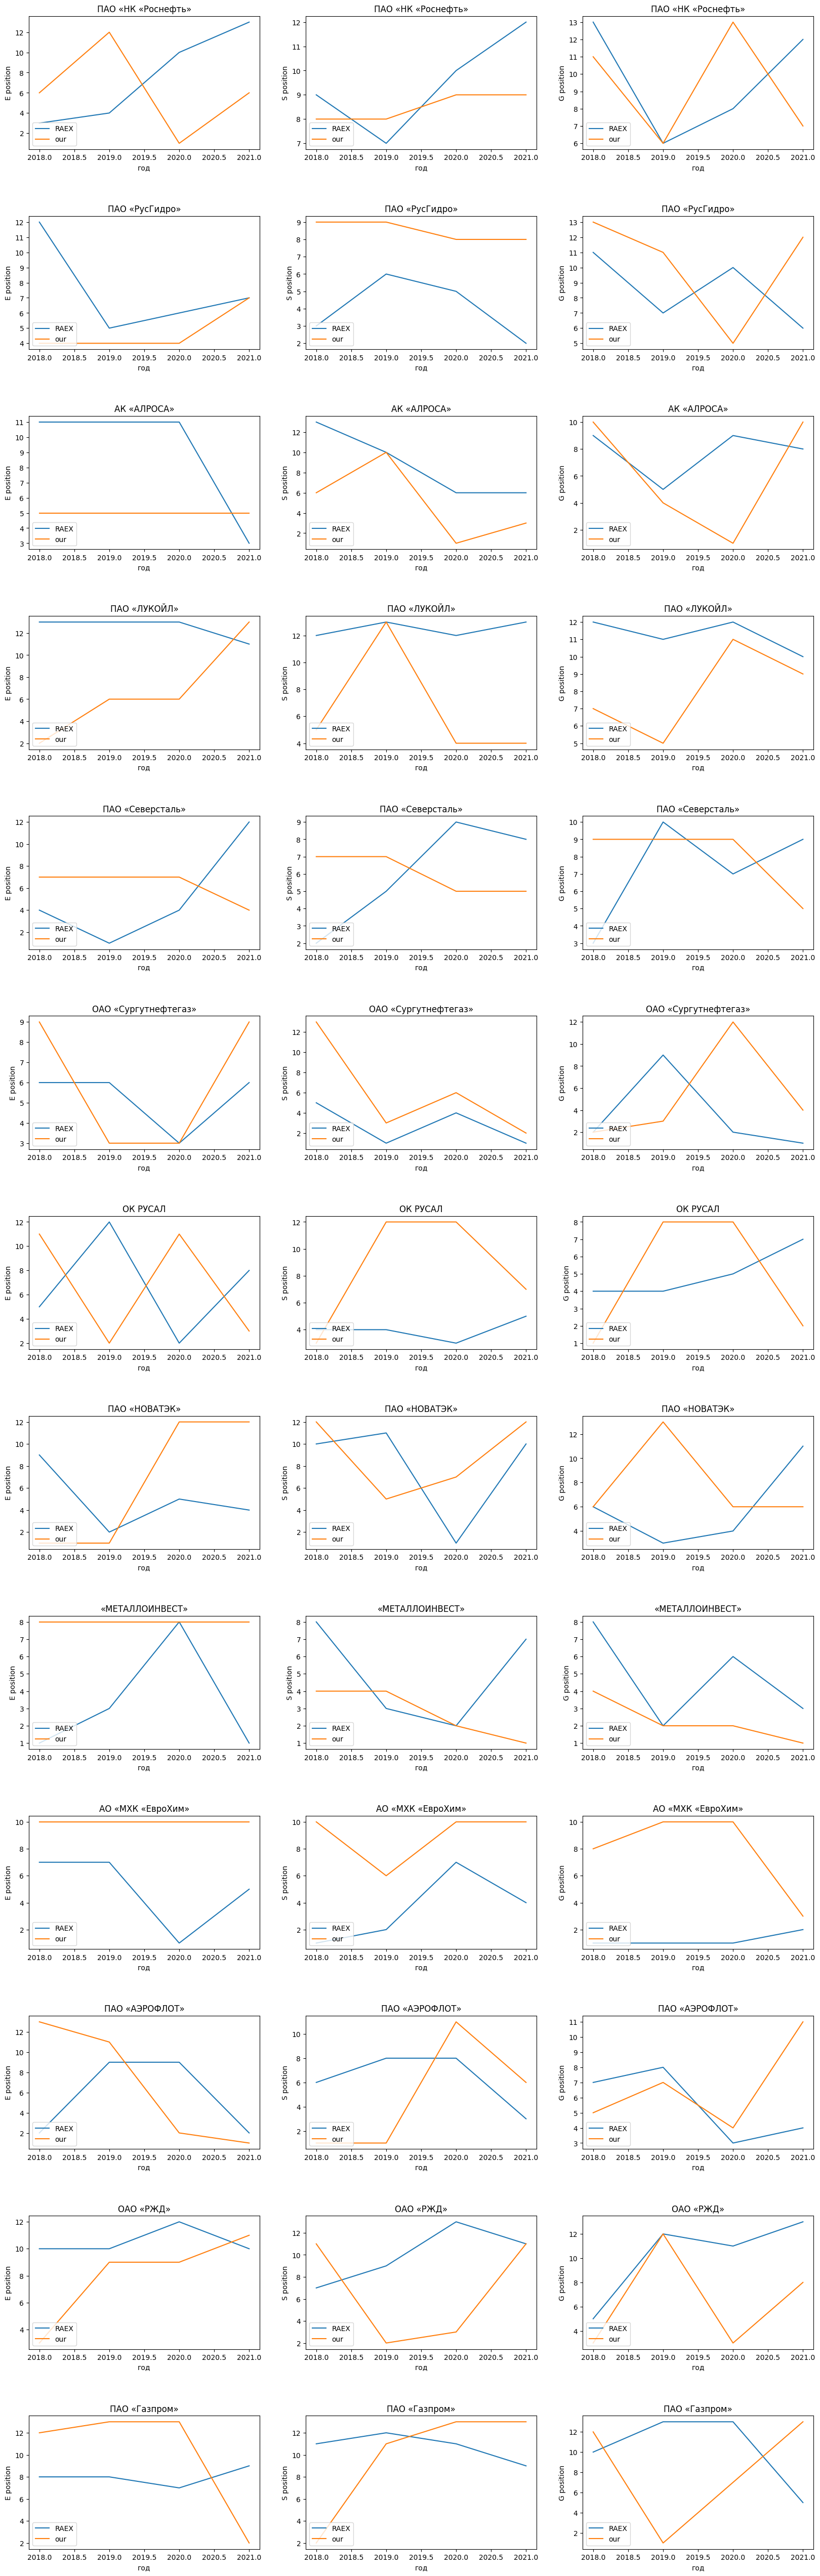

In [33]:
fig, axs = plt.subplots(13, 3, figsize=(20, 13*5))
plt.subplots_adjust(hspace=0.5)
for company_num, company in enumerate(companies_intersection):
    for label_num, label_ in enumerate(('E', 'S', 'G')):
        x1 = [2018, 2019, 2020, 2021]
        y1 = [raex_2018.loc[raex_2018['компания РСПП'] == company, label_].squeeze(),
              raex_2019.loc[raex_2019['компания РСПП'] == company, label_].squeeze(),
              raex_2020.loc[raex_2020['компания РСПП'] == company, label_].squeeze(),
              raex_2021.loc[raex_2021['компания РСПП'] == company, label_].squeeze()]
        x2 = df.loc[df['компания'] == company, 'год'].values
        y2 = df.loc[df['компания'] == company, label_].values

        axs[company_num, label_num].plot(x1, y1, label='RAEX')
        axs[company_num, label_num].plot(x2, y2, label='our')
        axs[company_num, label_num].legend(loc ='lower left')
        axs[company_num, label_num].set_xlabel('год')
        axs[company_num, label_num].set_ylabel(f'{label_} position')
        axs[company_num, label_num].set_title(company)
        
        extent = axs[company_num, label_num].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'images/{label_}_{company}.png', bbox_inches=extent.expanded(1.25, 1.2))
plt.show()

In [323]:
raex_df = pd.DataFrame(columns=df.columns)
raex_df.head()

,E,S,G,год,компания


In [324]:
raex_2021.rename(columns={'компания РСПП': 'компания'}, inplace=True)
raex_2020.rename(columns={'компания РСПП': 'компания'}, inplace=True)
raex_2019.rename(columns={'компания РСПП': 'компания'}, inplace=True)
raex_2018.rename(columns={'компания РСПП': 'компания'}, inplace=True)

In [325]:
raex_2021['год'] = 2021
raex_2020['год'] = 2020
raex_2019['год'] = 2019
raex_2018['год'] = 2018

In [326]:
raex_df = pd.concat([raex_2021, raex_2020, raex_2019, raex_2018])
raex_df.shape

(52, 5)

In [327]:
raex_df.head()

,E,S,G,компания,год
4,13,12,12,ПАО «НК «Роснефть»,2021
8,11,13,10,ПАО «ЛУКОЙЛ»,2021
12,10,11,13,ОАО «РЖД»,2021
13,12,8,9,ПАО «Северсталь»,2021
14,4,10,11,ПАО «НОВАТЭК»,2021


### Корреляция

In [342]:
df_matrix = df.sort_values(['компания','год'])[['E', 'S', 'G']].to_numpy()
raex_matrix = raex_df.sort_values(['компания','год'])[['E', 'S', 'G']].to_numpy()

In [343]:
np.corrcoef(df_matrix, raex_matrix)

array([[ 1.        ,  0.94491118,  1.        , ..., -0.83223972,
        -0.91766294,  0.97072534],
       [ 0.94491118,  1.        ,  0.94491118, ..., -0.96786784,
        -0.73704347,  0.83862787],
       [ 1.        ,  0.94491118,  1.        , ..., -0.83223972,
        -0.91766294,  0.97072534],
       ...,
       [-0.83223972, -0.96786784, -0.83223972, ...,  1.        ,
         0.54341298, -0.67470978],
       [-0.91766294, -0.73704347, -0.91766294, ...,  0.54341298,
         1.        , -0.98624138],
       [ 0.97072534,  0.83862787,  0.97072534, ..., -0.67470978,
        -0.98624138,  1.        ]])

In [344]:
df_matrix.shape

(52, 3)

In [345]:
np.corrcoef(df_matrix, raex_matrix).shape

(104, 104)

In [346]:
df_flatten = df_matrix.flatten()
raex_flatten = raex_matrix.flatten()
np.corrcoef(df_flatten, raex_flatten)[0,1]

-0.0009157509157509158

In [333]:
def correlation_coefficient(T1, T2):
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

In [334]:
correlation_coefficient(df_matrix, raex_matrix)

-0.0009157509157509158

In [335]:
df_matrix = df.sort_values(['компания','год'])
raex_matrix = raex_df.sort_values(['компания','год'])

In [336]:
df_matrix['E'].corr(raex_matrix['E'])

0.004874172374868175

In [337]:
df_matrix['S'].corr(raex_matrix['S'])

-0.21322878893234715

In [338]:
df_matrix['G'].corr(raex_matrix['G'])

-0.1953848587645115

In [339]:
from scipy.stats import pearsonr, spearmanr, kendalltau

In [347]:
pearsonr(df_matrix.flatten(), raex_matrix.flatten())[0]

-0.0009157509157509072

In [348]:
spearmanr(df_matrix.flatten(), raex_matrix.flatten())[0]

-0.0009157509157509159

In [349]:
kendalltau(df_matrix.flatten(), raex_matrix.flatten())[0]

0.00275997150997151

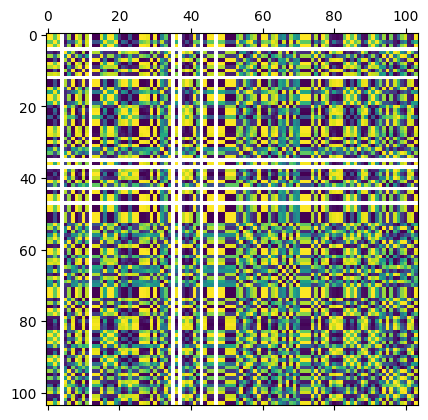

In [241]:
plt.matshow(np.corrcoef(df_matrix, raex_matrix))

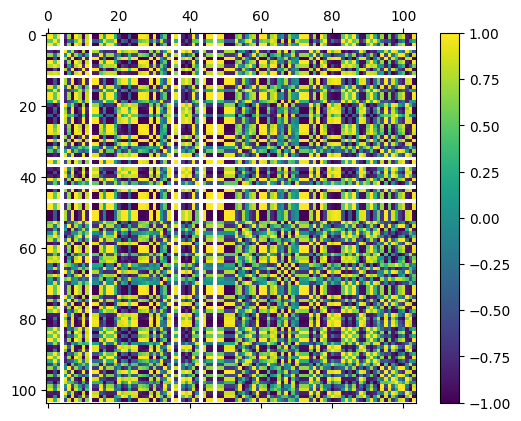

In [242]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(np.corrcoef(df_matrix, raex_matrix))
fig.colorbar(cax)
plt.show()